3D data, 
`like:
x0, y0, spectrum
x1, y0, spectrum
...
x0, y1, spectrum
x1, y1, spectrum
...
x0, yn, spectrum
x1, yn, spectrum
`

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import mathmethod

In [2]:
def contourplot(X, Y, data, level_number, data_min, data_middle, data_max, 
                color = 'bwr', peak = True, linthresh = 5e1):
    nbins = level_number//2
    #make levels evenly spaced between min to middle and middle to max#
    levels1 = np.linspace(data_min, data_middle, nbins)
    levels2 = np.linspace(data_middle, data_max, nbins)[1:]
    levels = np.concatenate([levels1, levels2])
    if not peak:
        linthresh = 1e6 
    cmap = plt.get_cmap(color)
    fig = plt.figure(figsize = (int(X.shape[0]/Y.shape[0]*6), 4), dpi = 200)
    ax = plt.subplot(111)
    cf = ax.contourf(X, Y, data, cmap = cmap, levels = levels, vmin = data_min, vmax = data_max, norm = colors.SymLogNorm(linthresh = linthresh, linscale = 1))
    ax.set_xlabel('X(um)')
    ax.set_ylabel('Y(um)')
    #crop the image if necessary#
    #ax.set_xlim([X.min(), X.max() - 1])
    #ax.set_ylim([Y.min(), 2])
    plt.colorbar(cf, ticks=[data_min, data_middle, data_max], format = '%.3f')

In [3]:
file_path = './PL_Map_BN_G_WSe2_Map_Data2.txt'

def process_data(file_path, flag):
    raw = np.genfromtxt(file_path)
    spectrum = Z_axis = raw[0][2:]
    #initialize x axis#
    X_axis = [raw[1][1]]
    for i in range(2, len(raw) - 1):
        if raw[i][1] == X_axis[0]:
            break
        X_axis.append(raw[i][1])
    X_axis_length = len(X_axis)
    #inital Y axis and data matrix#
    Y_axis_length = int((len(raw) - 1)/X_axis_length)
    data = [[] for i in range(Y_axis_length)]
    data_spectrum = [[] for i in range(Y_axis_length)]
    Y_axis = []
    for i in range(Y_axis_length):
        Y_axis.append(raw[i * X_axis_length + 1][0])
        for j in range(X_axis_length):
            data_remove_background = mathmethod.sub_line(Z_axis, list(raw[i * X_axis_length + 1 + j][2:])) #subtract linear background
            data_spectrum[i].append(data_remove_background)
            if flag == 'peak':
                #data_smoothed = mathmethod.smoothing(data_remove_background, n)
                #MAX = max(data_smoothed)
                MAX = max(data_remove_background)
                data[i].append(MAX)
            if flag == 'integration':
                integration = np.trapz(data_remove_background)
                data[i].append(integration)
            if flag == 'shift':
                shift_index = np.argmax(data_remove_background)
                shift = Z_axis[shift_index]
                data[i].append(shift)
    data_spectrum = np.asarray(data_spectrum)
    X_axis = np.array(X_axis)
    Y_axis = np.array(Y_axis)
    data = np.array(data)
    #smooth 2D plot#
    data_smooth = mathmethod.smooth_2Darray2(data, 0, 0)
    data_smooth /= data_smooth.max()/100

    #bad point deletion#
    data_smooth[data_smooth < -3] /= 1000
    
    return X_axis, Y_axis, data_smooth, data_spectrum, spectrum

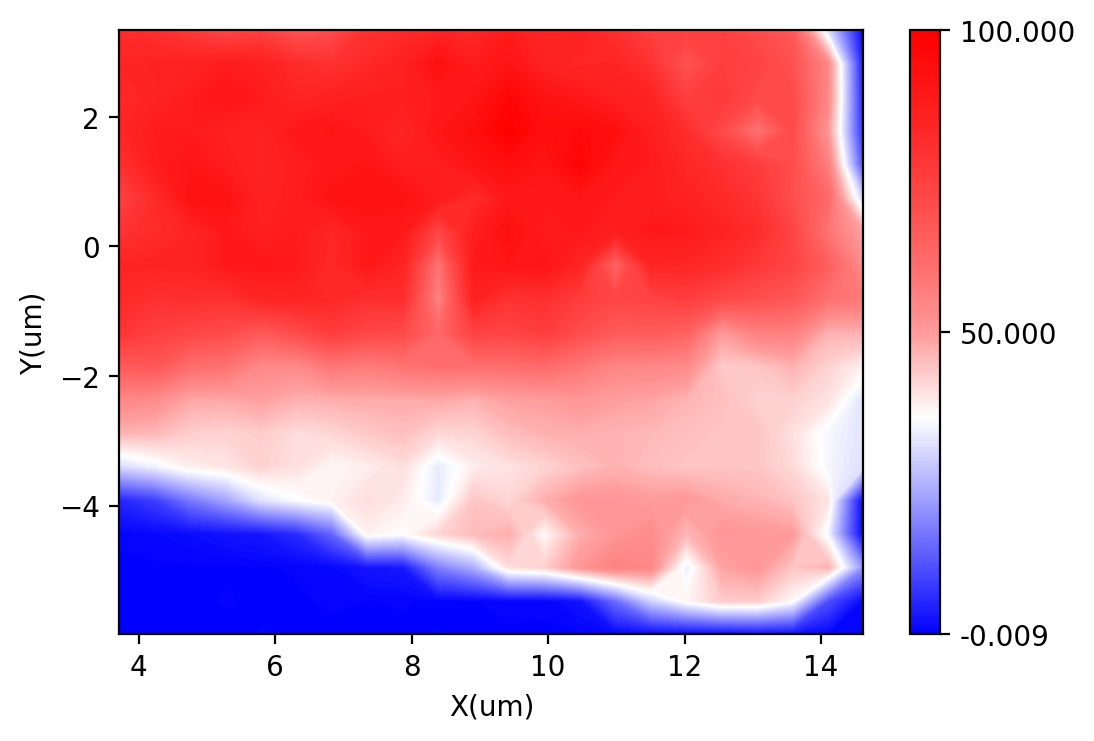

In [4]:
#integration
X_axis, Y_axis, data_smooth, data_spectrum, spectrum = process_data(file_path, flag = 'integration')
contourplot(X_axis, -Y_axis, data_smooth, level_number = 200, 
            data_min = data_smooth.min(), data_middle = 50, 
            data_max = data_smooth.max(), linthresh = 5e1)

#peak shift
# X_axis, Y_axis, data_smooth, data_spectrum, spectrum = process_data(file_path, flag = 'shift')
# contourplot(X_axis, -Y_axis, data, level_number = 100, data_min = 1.58, 
#            data_middle = 1.65, data_max = 1.70, peak_or_shift = False)

In [5]:
#map 2d data to 1d
data_cluster = data_smooth.reshape(-1, 1)
data_indices = np.array([[i, j] for j in range(data_smooth.shape[1]) 
                        for i in range(data_smooth.shape[0])])

In [6]:
#DBscan
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 1.5, min_samples = 3, metric = 'euclidean')
y_db = db.fit_predict(data_cluster) #-1 are outliers

In [7]:
#KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3)
y_km = km.fit_predict(data_cluster)

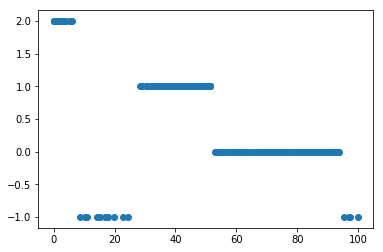

In [8]:
def cluster_show(data_cluster, y):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.scatter(data_cluster.ravel(), y)
cluster_show(data_cluster, y_db)

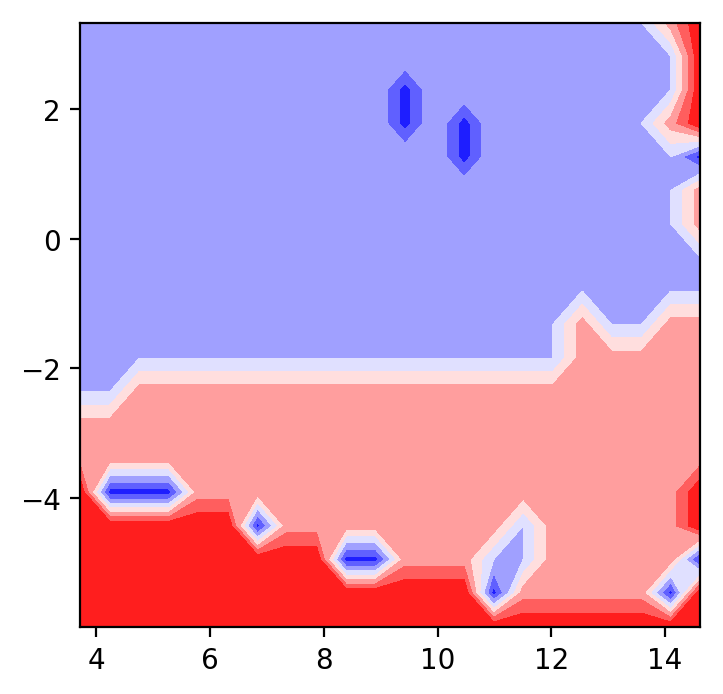

In [9]:
#plot region
def plot_region(X, Y, y, color):
    data_Z = y.reshape(data_smooth.shape)
    cmap = plt.get_cmap(color)
    fig = plt.figure(figsize = (int(X.shape[0]/Y.shape[0]*4), 4), dpi = 200)
    ax = plt.subplot(111)
    cf = ax.contourf(X, -Y, data_Z, cmap = cmap)
plot_region(X_axis, Y_axis, y_db, 'bwr')

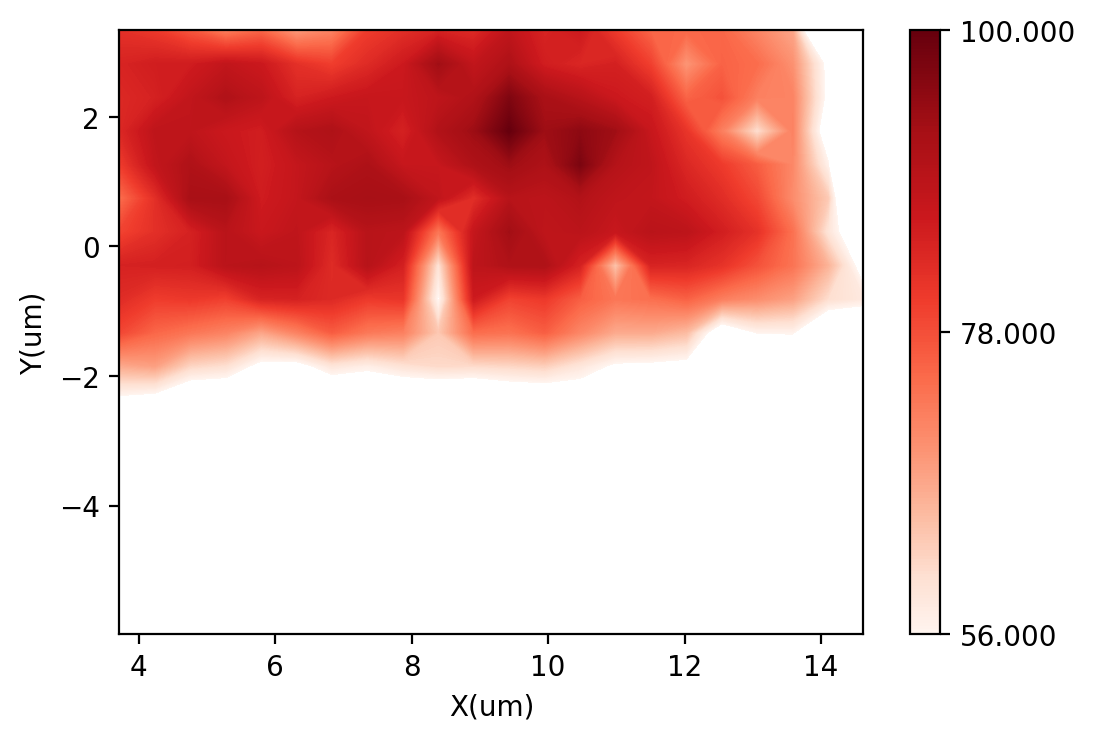

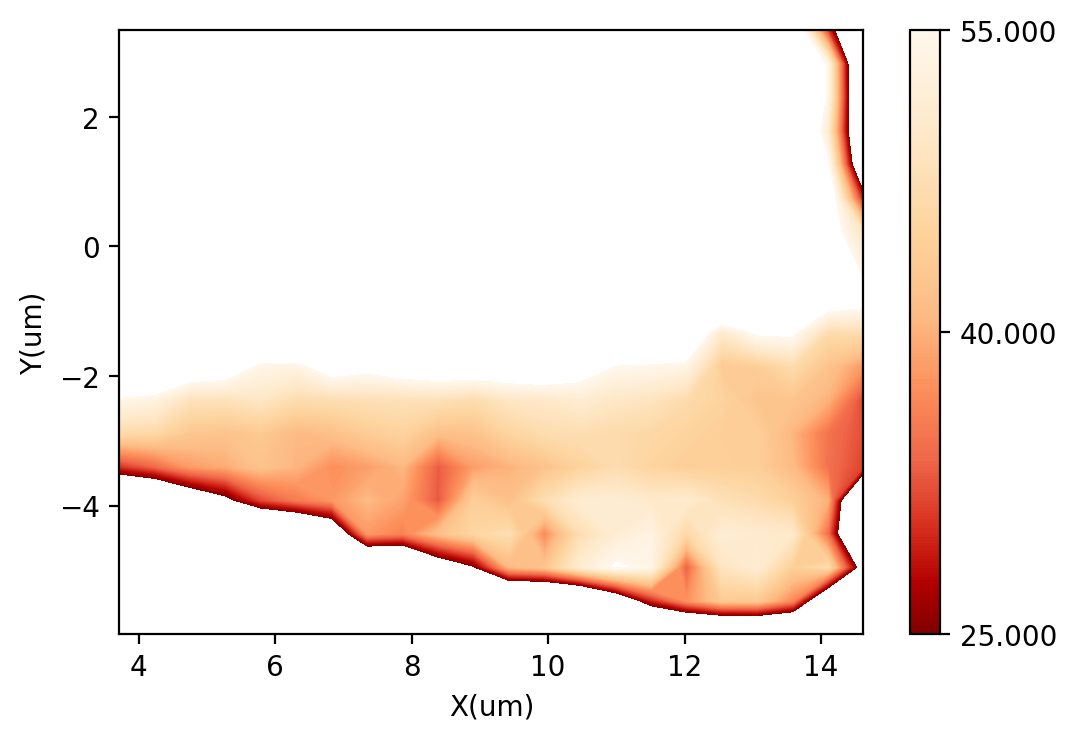

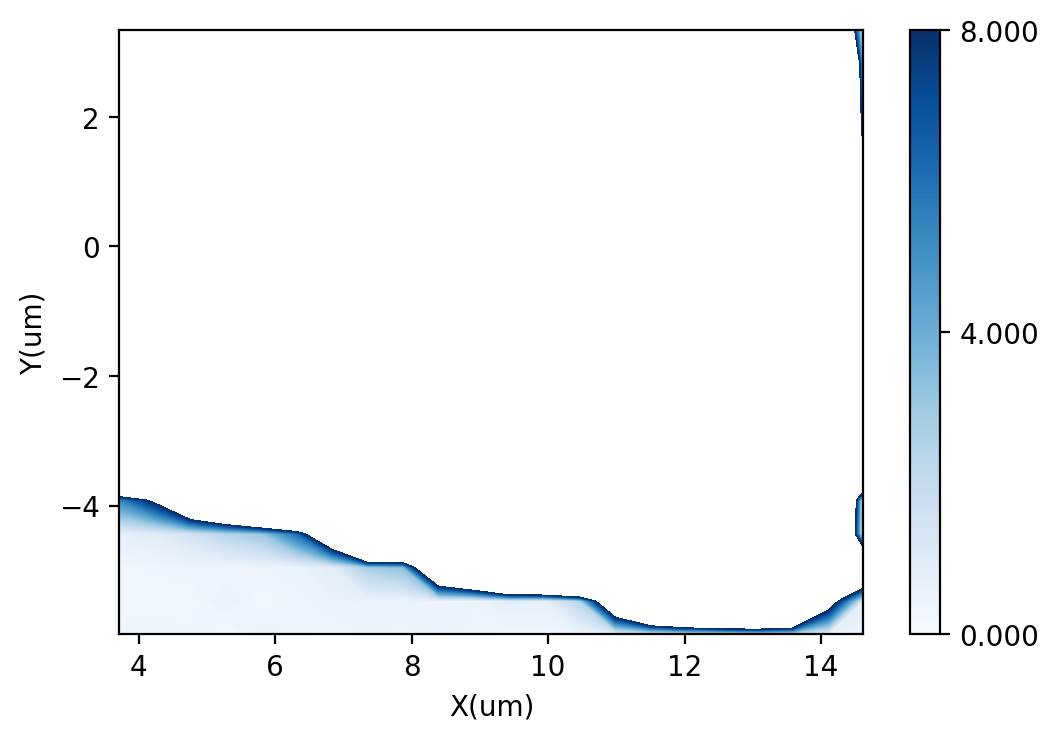

In [10]:
#area selection
def area(X_min, X_max, color = 'bwr', linthresh = 1e1):   
    contourplot(X_axis, -Y_axis, data_smooth, level_number = 200, 
                data_min = X_min, data_middle = (X_min + X_max)/2, 
                data_max = X_max, color = color, linthresh = linthresh)
area(56, 100, color = 'Reds')
area(25, 55, color = 'OrRd_r')
area(0, 8, color = 'Blues')